In [23]:

import numpy as np
import cv2
import os
import sys
import sklearn
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import training_temp
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap


In [24]:
# Hyperparameters and settings
batch_size = 64
test_batch_size = 64
input_size = 1 # because there is only one channel 
output_size = 4
num_epochs = 10
learning_rate = 0.001


In [25]:
# Load training, validation and training data

data_loader = torch.load('data_loader.pt')
valid_loader = torch.load('valid_loader.pt')
test_loader = torch.load('test_loader.pt')


In [26]:
# load model architectures from training_temp.py
model1 = training_temp.CNN()
model2 = training_temp.CNN2()
model3 = training_temp.CNN3()
model4 = training_temp.CNN4()


In [27]:
#load the weights of the models
model1.load_state_dict(torch.load('CNN.pth', map_location=torch.device('cpu')))
model2.load_state_dict(torch.load('../models/augmented_greyscale_batch_size(2048)/CNN2.pth', map_location=torch.device('cpu')))
model3.load_state_dict(torch.load('../models/augmented_greyscale_batch_size(2048)/CNN3.pth', map_location=torch.device('cpu')))

RuntimeError: Error(s) in loading state_dict for CNN:
	size mismatch for fc_layer.6.weight: copying a param with shape torch.Size([4, 512]) from checkpoint, the shape in current model is torch.Size([10, 512]).
	size mismatch for fc_layer.6.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([10]).

In [ ]:
# make confusion matrix based on test results
def confusion_matrix_data(model, test_loader):
    model.eval()
    predictions = []
    actual_labels = []
    f1_list = []
    recall_list = []
    precision_list = []
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.numpy())
            actual_labels.extend(labels.numpy())
        # print(predictions)
        # print(actual_labels)

    return predictions, actual_labels

In [ ]:
def calculate_model_performance_stats(model, test_loader):
    data_out = {}

    predictions, actual_labels = confusion_matrix_data(model, test_loader)

    data_out['name'] = model.name
    data_out['predictions'] = predictions
    data_out['actual_labels'] = actual_labels
    data_out['f1_macro'] = sklearn.metrics.f1_score(actual_labels, predictions, average='macro')
    data_out['f1_micro'] = sklearn.metrics.f1_score(actual_labels, predictions, average='micro')
    data_out['recall_macro'] = sklearn.metrics.recall_score(actual_labels, predictions, average='macro')
    data_out['recall_micro'] = sklearn.metrics.recall_score(actual_labels, predictions, average='micro')
    data_out['precision_macro'] = sklearn.metrics.precision_score(actual_labels, predictions, average='macro')
    data_out['precision_micro'] = sklearn.metrics.precision_score(actual_labels, predictions, average='micro')
    data_out['accuracy'] = sklearn.metrics.accuracy_score(actual_labels, predictions)
    
    cf_matrix = sklearn.metrics.confusion_matrix(actual_labels, predictions)
    classes = {'focused': 0, 'happy': 1, 'neutral': 2, 'surprised': 3}
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [key for key in classes],
                        columns = [key for key in classes])

    plt.figure(figsize = (12,7))
    #set labels

    # https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
    #add label to heatmap
    plt.title('Confusion Matrix for %s'%(model.name))
    
    #colour mapping for heatmap
    # colour_gradient = ["#E72A24", "#D2C631", "#31B329", "#00FFFF", "#0047AB"] # red, yellow, green, cyan, blue
    colour_gradient = ["#E72A24", "#FF8000" ,"#D2C631", "#31B329", "#00FFFF"] # red, yellow, green, cyan, blue
    # positions = [0.0, 0.10, 0.30, 0.50, 1.0]
    positions = [0.0, 0.10, 0.20, 0.60, 1.0] 
    custom_cmap = LinearSegmentedColormap.from_list("blue-to-red", list(zip(positions, colour_gradient)))
    
    sn.heatmap(df_cm, annot=True, cmap = custom_cmap).set(xlabel='Predicted Class', ylabel='Actual Class')
    plt.savefig('matrix_%s.png'%(model.name))
    return data_out

Macro precision for :  CNN 0.993342151675485
Micro precision for :  CNN 0.9933333333333333
Macro recall for :  CNN 0.99375
Micro recall for :  CNN 0.9933333333333333
Macro F1 for :  CNN 0.9934840868558397
Micro F1 for :  CNN 0.9933333333333333
Accuracy for :  CNN 0.9933333333333333
__________________________________________________

Macro precision for :  CNN2 1.0
Micro precision for :  CNN2 1.0
Macro recall for :  CNN2 1.0
Micro recall for :  CNN2 1.0
Macro F1 for :  CNN2 1.0
Micro F1 for :  CNN2 1.0
Accuracy for :  CNN2 1.0
__________________________________________________

Macro precision for :  CNN3 1.0
Micro precision for :  CNN3 1.0
Macro recall for :  CNN3 1.0
Micro recall for :  CNN3 1.0
Macro F1 for :  CNN3 1.0
Micro F1 for :  CNN3 1.0
Accuracy for :  CNN3 1.0
__________________________________________________



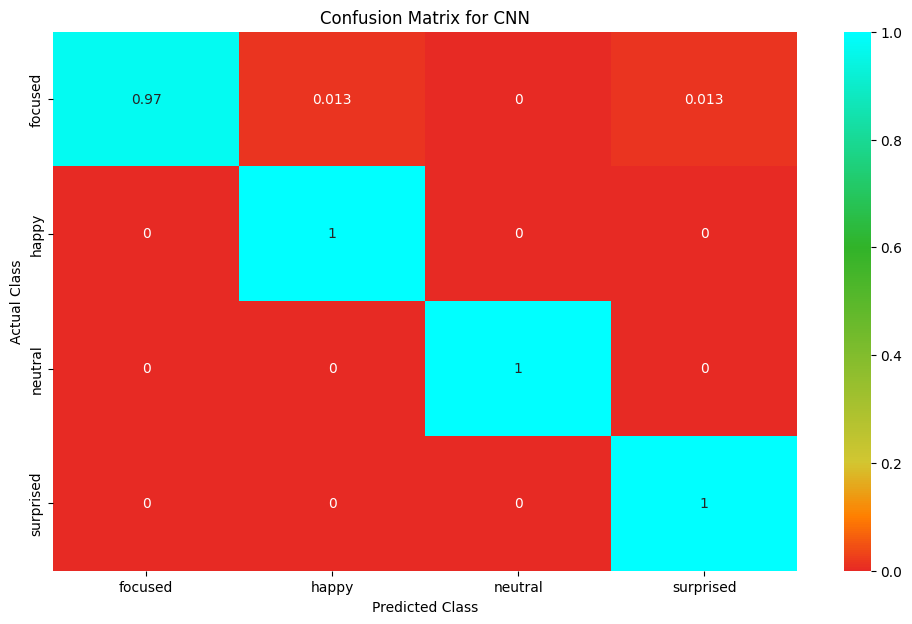

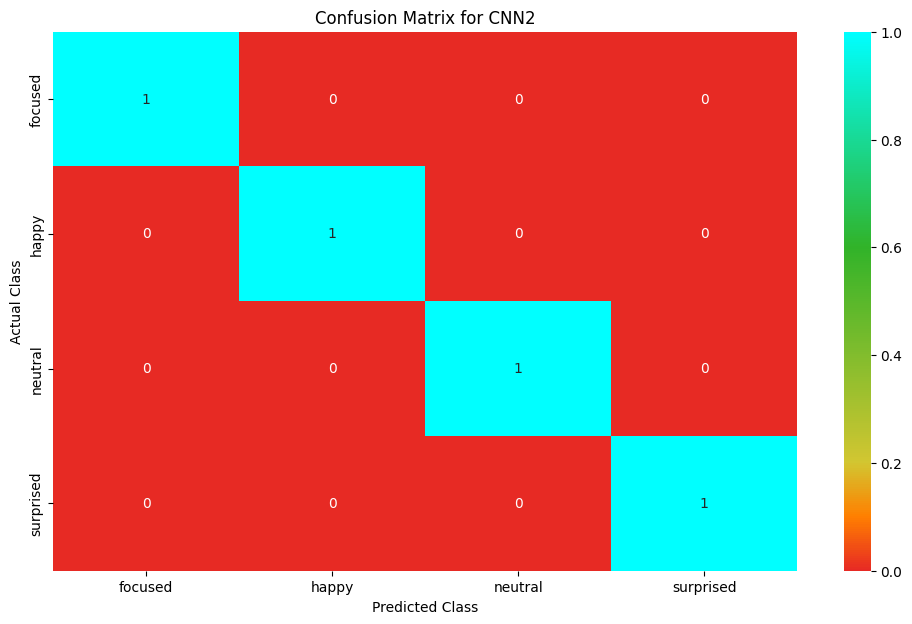

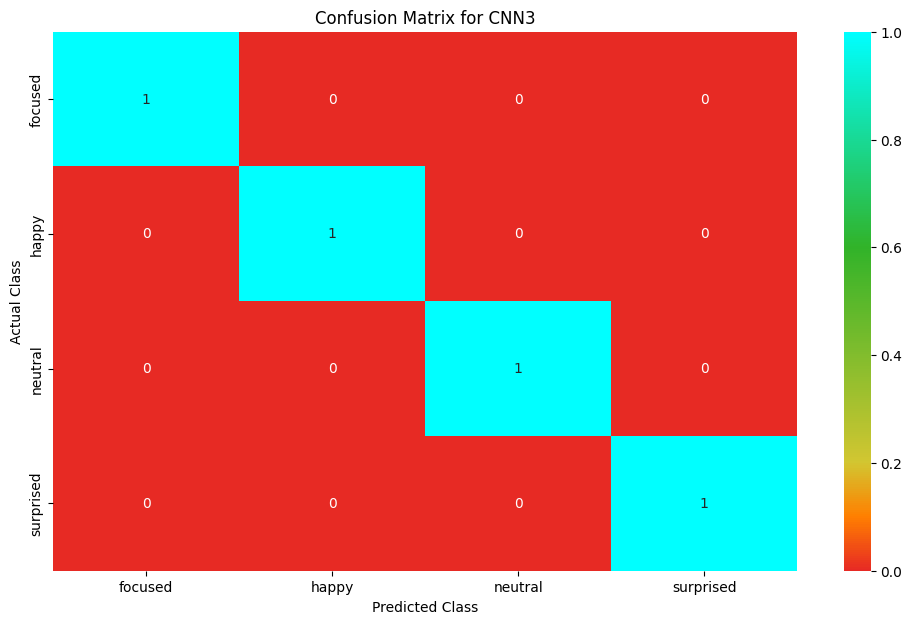

In [ ]:
# printing the performance stats for each model
#NOTE: Average on micro would always be equal to accuracy since all classes have equal weights in the case of the project.
data_dicts = {'name': [], 'precision_micro': [], 'precision_macro': [], 'recall_micro': [], 'recall_macro': [], 'f1_micro': [], 'f1_macro': [], 'accuracy': []}
for model in [model1, model2, model3]:
    data_out = calculate_model_performance_stats(model, test_loader)
    print("Macro precision for : ", model.name, data_out['precision_macro'])
    print("Micro precision for : ", model.name, data_out['precision_micro'])
    print("Macro recall for : ", model.name, data_out['recall_macro'])
    print("Micro recall for : ", model.name, data_out['recall_micro'])
    print("Macro F1 for : ", model.name, data_out['f1_macro'])
    print("Micro F1 for : ", model.name, data_out['f1_micro'])
    print("Accuracy for : ", model.name, data_out['accuracy'])
    print("__________________________________________________\n")

    for key in data_dicts.keys():
        data_dicts[key].append(data_out[key])

In [ ]:
#tabulating the CNN metrics using pandas
df = pd.DataFrame(data_dicts)

#set index to "name" column which is for CNN names
df = df.set_index('name', inplace=False)

#reorder columns
df = df[['precision_macro', 'recall_macro', 'f1_macro', 'precision_micro', 'recall_micro', 'f1_micro', 'accuracy']]


In [ ]:
display(df)

,precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro,accuracy
name,,,,,,,
CNN,0.993342,0.99375,0.993484,0.993333,0.993333,0.993333,0.993333
CNN2,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
CNN3,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#saving the CNN metrics to a .csv file
df.to_csv("evaluation_stats.csv")